# Future projections of global hail hazard

In [3]:
%cd ~/git/future_hail_global

/home/561/tr2908/git/future_hail_global


In [4]:
import os
import sys

sys.path.append(f'{os.path.expanduser("~")}/git/xarray_parcel/')
sys.path.append(f'{os.path.expanduser("~")}/git/aus400_hail/')
sys.path.append(f'{os.path.expanduser("~")}/git/warming_levels/')
                
import itertools
import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray
from dask.distributed import Client
from matplotlib.colors import TwoSlopeNorm
import modules.fut_hail as fh

## Setup

In [5]:
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})
client = Client(n_workers=8, threads_per_worker=4)
client

<Client: 'tcp://127.0.0.1:35013' processes=8 threads=32, memory=125.18 GiB>

## Settings

In [6]:
# ruff: noqa: E712                                # Don't check rule E712 in Ruff.
plt.show()                                        # Start the plotting engine.
plt.rcParams['font.size'] = 16                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

lats = {'asia': slice(0, 55),                    # Latitudes for selected world regions.
        'oceania': slice(-48, 0),
        'north_america': slice(12, 60),
        'south_america': slice(-57, 12),
        'europe': slice(25, 70),
        'africa': slice(-37, 25)}

lons = {'asia': slice(55, 147),                   # Longitudes for selected world regions.
        'oceania': slice(98, 180),
        'north_america': slice(-130, -50),
        'south_america': slice(-100, -20),        
        'europe': slice(-12, 55),
        'africa': slice(-20, 55)}

region_names = {'asia': 'Asia',                   # Display names for selected world regions.
                'oceania': 'Oceania',
                'north_america': 'North America',
                'south_america': 'South America',
                'europe': 'Europe',
                'africa': 'Africa'}

## Model selection

Find models matching criteria. The following criteria are used to select models:

* Must contain variables:
     - `tas`, temperature at surface
     - `ta`, temperature by level
     - `uas`, u wind at surface
     - `ua`, u wind by level
     - `vas`, v wind at surface
     - `va`, v wind by level
     - `huss`, specific humidity at surface
     - `hus`, specific humidity by level
     - `ps`, surface pressure
* Must be available with a table ID of `3hr` or `6hrLev` (six hour minimum temporal resolution).
* Must include both `historical` and `ssp585` experiments.
* Must be available locally on NCI.

In [ ]:
models = fh.select_all_models()

In [ ]:
models

Now that models are selected, define runs over 20 year periods. We filter out models that
- do not cover the required times or
- are not available on pressure levels.

In [ ]:
runs = fh.define_runs(models=models)

In [ ]:
runs[['model', 'ensemble', 'exp', 'start_year', 'end_year']]

If `orog` is available for surface elevation it is used. Some models are missing it, however, and if missing, orography from CNRM-CM6-1/historical/r1i1p1f2 is interpolated to the same grid and used. This code produce the backup orography per model with missing orography. It will not regenerate already-generated files. Note that the use of xemsf gridding routines seems to crash dask processes run using MPI on gadi, so this regridding has to be done "offline" here.

In [ ]:
fh.make_backup_orography(runs)

In [ ]:
runs.to_csv('results/runs_list.csv', index=False)

In [ ]:
fh.plot_run_years(runs, file='results/supplementary/run_years.pdf')

Note that grid information is missing from some files for MRI, CMCC, and MPI. The missing information is (as of 19.05.2023):

```
MRI: grid-spec gn, orog version gn/v20190603
CMCC: grid-spec gn, orog version gn/v20210126
MPI: grid-spec gn, orog version gn/v20190710
```

## Process CMIP6 data

Scripts are generated for each model/experiment, under
    
```
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-1.sh
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-2.sh
```

The first processes the first 10 years, the second the last 10 years.

Uncomment the following block to (re)create all scripts for generating convective indices for each run. 

In [ ]:
# fh.make_run_scripts(runs=runs)

Post-processing into annual/seasonal statistics is done by writing the epochs to process to a CSV file:

In [ ]:
# fh.make_postprocessing_scripts(runs=runs)

and then ensuring the job IDs match the number of epochs and running the script

```
post_process_CMIP.sh
```

in each run subdirectory. Then, run the script 

```
calc_proxies_CMIP.sh
calc_proxies_era5.sh
```

to add the proxy information.

After processing, check that all files have the correct epoch.

In [ ]:
fh.assert_epochs(runs=runs)

## Read processed data

In [7]:
dat, landmask = fh.read_processed_data(apply_landmask=False)

Add processed crop information.

In [63]:
dat = xarray.merge([dat, fh.crop_hail_stats(dat=dat)])

Also read in ERA5 data.

In [64]:
era5 = fh.era5_climatology(landmask=None)

## Global hail climatology for historical period

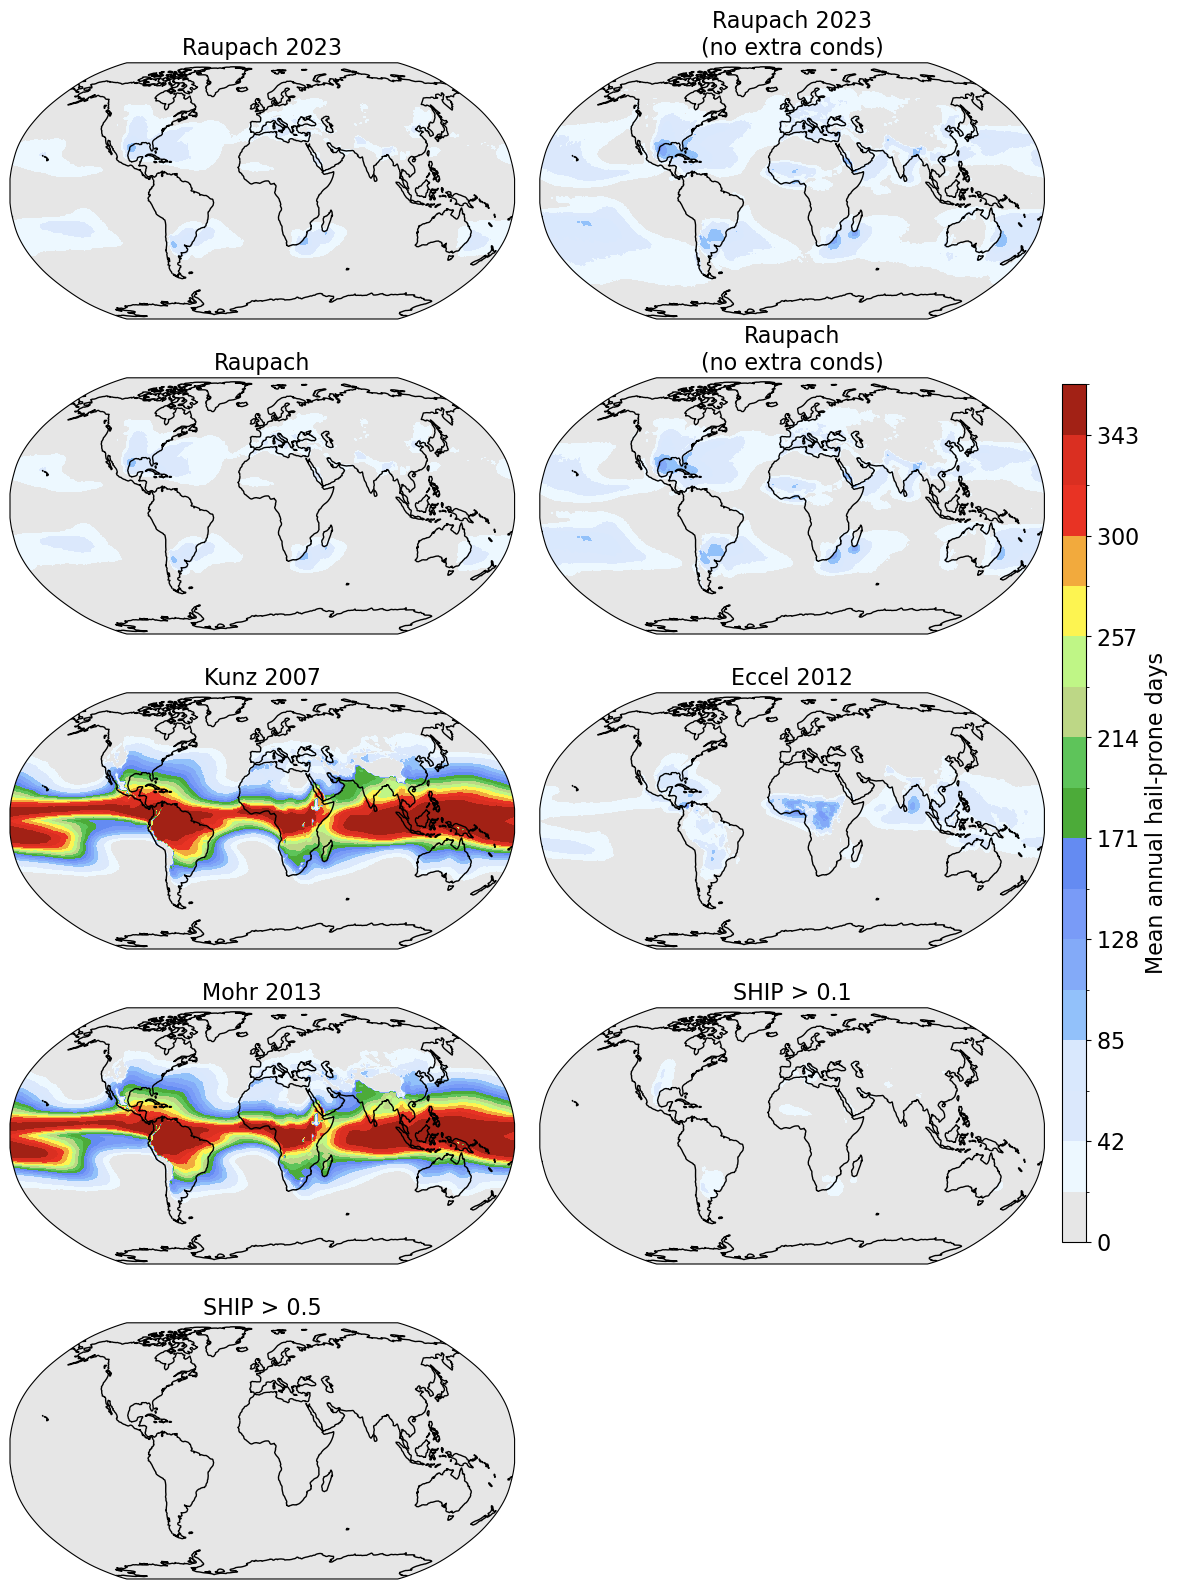

In [65]:
_ = fh.plot_map([era5.annual_hail_days.sel(proxy=f) for f in list(fh.proxy_dims)], 
                title=[f'{fh.proxy_dims[f]}' for f in list(fh.proxy_dims)], 
                grid=False, contour=True, disp_proj=ccrs.Robinson(), ncols=2, nrows=5, figsize=(12,15.6),
                share_scale=True, scale_label='Mean annual hail-prone days',
                file='results/supplementary/era5_all_proxies.pdf')

We see from the above plot that some proxies such as that of Mohr 2013 and Kunz 2007 produce too many hail-prone days in the tropics because they were trained in a European context. On the other hand the threshold of 0.5 on SHIP produces too few hail-prone days globally. The previous and updated Raupach proxies are very similar so we use only the updated versions. We therefore subset the proxies considered in this study to exclude these proxies.

In [66]:
proxies = ['Raupach2023_updated',
           'Raupach2023_updated_noconds',
           'Eccel2012',
           'SHIP_0.1']

era5 = era5.sel(proxy=proxies)
dat = dat.sel(proxy=proxies)

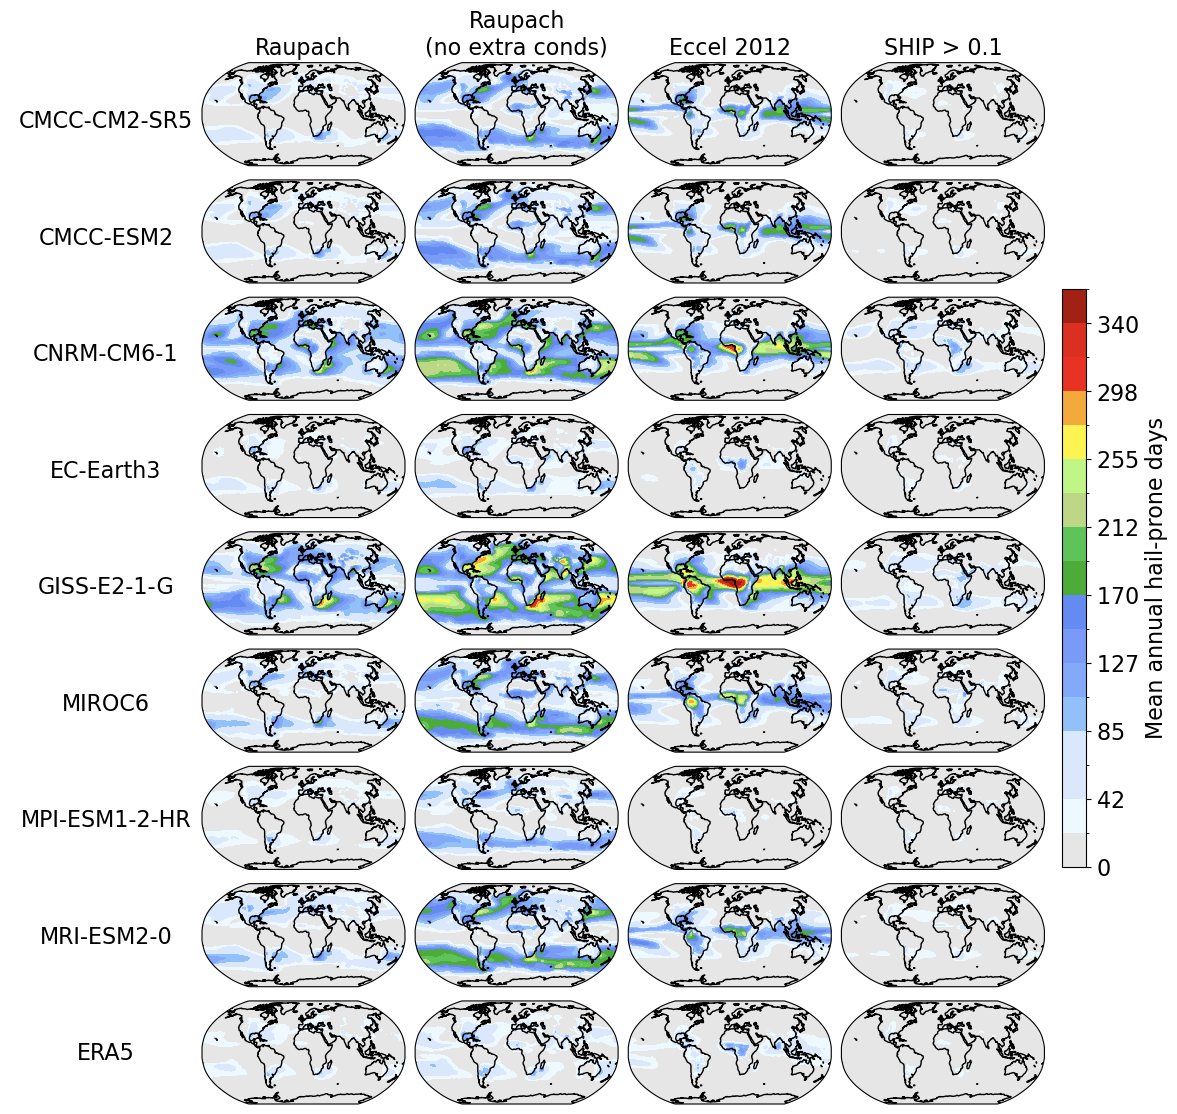

In [67]:
d = dat.sel(epoch='historical').mean('year_num')
_ = fh.plot_map([d.annual_hail_days.sel(model=m, proxy=p) for m, p in itertools.product(dat.model.values, proxies)] + [era5.annual_hail_days.sel(proxy=p) for p in proxies],
                title=[f'{m}, {fh.proxy_dims[p]}' for m, p in itertools.product(dat.model.values, proxies)] + [f'ERA5, {fh.proxy_dims[p]}' for p in proxies], 
                figsize=(12,10.5), disp_proj=ccrs.Robinson(), ncols=4, nrows=9, share_scale=True, share_axes=True, grid=False, contour=True, 
                col_labels=[fh.proxy_dims[f] for f in proxies], row_labels=list(dat.model.values) + ['ERA5'], 
                row_label_rotation=0, row_label_adjust=0.16, row_label_scale=1.28, row_label_offset=-0.056,
                scale_label='Mean annual hail-prone days', file='results/supplementary/historical_by_model.pdf')
del d

The next plot shows a comparison between the model mean climatology from CMIP6 and ERA5.

In [68]:
cmip6_overall_mean = dat.sel(epoch='historical', proxy=proxies).annual_hail_days.mean(['model', 'proxy', 'year_num'])
era5_overall_mean = era5.sel(proxy=proxies).annual_hail_days.mean('proxy')

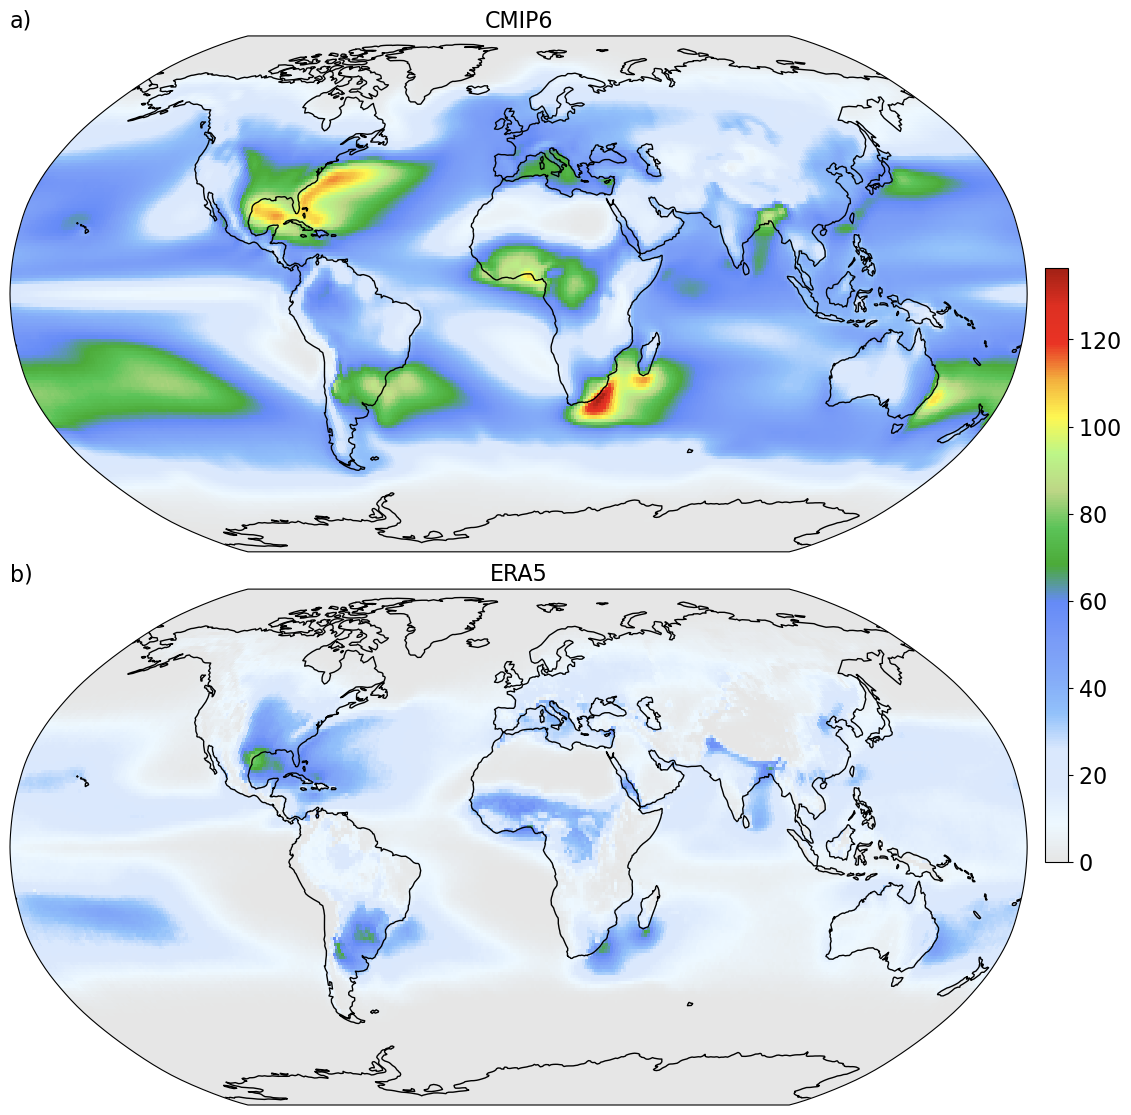

In [69]:
_ = fh.plot_map([cmip6_overall_mean, era5_overall_mean], title=['CMIP6', 'ERA5'], cbar_label='', nan_colour='white',
                figsize=(11.8,10.8), ncols=1, nrows=2, share_scale=True, share_axes=True, grid=False,
                disp_proj=ccrs.Robinson(), file='results/main/CMIP6_ERA5_comparison_historical.pdf', letter_labels=True)

Looking at the same map without the 'extra conditions' on the proxy, we see that the extra conditions are useful in reducing the number of hail-prone days at low and middle-high latitudes.

## Proxy anomalies for particular hail events

Here we look at anomalies in ERA5 proxy-derived monthly hail-prone days for June 2022 over Europe and February/March 2015 over India. In both these cases there were large hailstorm outbreaks.

In [ ]:
anoms = fh.monthly_era5_anoms(era5=era5)

In [ ]:
fh.plot_era5_anomalies(anoms=anoms, year=2022, lats=slice(35,60), lons=slice(-12,30), 
                       file='results/supplementary/monthly_anoms_France_2022.pdf')

In [ ]:
fh.plot_era5_anomalies(anoms=anoms, year=2015, lats=slice(0,40), lons=slice(55,100), figsize=(12,7), ncols=4, nrows=3,
                       file='results/supplementary/monthly_anoms_India_2015.pdf')

In [ ]:
_ = fh.plot_map([anoms.sel(year=2015, month=3, lat=slice(0,45), lon=slice(55,100)).monthly_hail_days,
                 anoms.sel(year=2022, month=6, lat=slice(25,70), lon=slice(-15,30)).monthly_hail_days], 
                title=['February 2015', 'June 2022'], ncols=2, cmap='RdBu_r', divergent=True, share_scale=True,
                wspace=0.17, figsize=(12,5), letter_labels=True, nan_colour='white',
                file='results/main/case_anomalies.pdf')

## Differences between epochs

Load calculated differences (code below takes ~1h40 to calculate from scratch). 

In [19]:
analysis_variables = ['annual_hail_days', 'seasonal_hail_days', 
                      'annual_mean_mixed_100_cape', 'annual_extreme_mixed_100_cape',
                      'annual_mean_shear_magnitude', 'annual_extreme_shear_magnitude',
                      'annual_mean_mixed_100_cin', 'annual_extreme_mixed_100_cin',
                      'annual_mean_mixed_100_lifted_index', 'annual_extreme_mixed_100_lifted_index',
                      'annual_mean_lapse_rate_700_500', 'annual_extreme_lapse_rate_700_500',
                      'annual_mean_temp_500', 'annual_extreme_temp_500',
                      'annual_mean_melting_level', 'crop_hail_prone_proportion']
assert [x in list(dat.keys()) for x in analysis_variables], 'Analysis variable missing from dat'

In [20]:
epoch_diffs = fh.epoch_differences(dat=dat, variables=analysis_variables)
assert np.all([f'{x}_mean_diff' in epoch_diffs.data_vars for x in analysis_variables]), 'Variable missing.'

Processing CMCC-CM2-SR5...
Processing CMCC-ESM2...
Processing CNRM-CM6-1...
Processing EC-Earth3...
Processing GISS-E2-1-G...
Processing MIROC6...
Processing MPI-ESM1-2-HR...
Processing MRI-ESM2-0...


Calculate multi-model, multi-proxy differences for plotting.

In [ ]:
mm_diffs_abs, mm_diffs_rel, mm_sig, mm_reference = fh.multi_model_mean_diffs(dat=epoch_diffs, variables=analysis_variables)

### Differences in annual hail-prone days, by model and proxy

First for 2C:

In [ ]:
fh.plot_diffs_for_epoch(diffs=epoch_diffs, epoch='2C', file='results/supplementary/hail_diffs_2C.pdf')

And for 3C:

In [ ]:
fh.plot_diffs_for_epoch(diffs=epoch_diffs, epoch='3C', file='results/supplementary/hail_diffs_3C.pdf')

### Multi-model, multi-proxy mean differences by epoch

In [ ]:
_ = fh.plot_map([mm_diffs_abs.annual_hail_days.sel(epoch=e) for e in ['2C', '3C']], nrows=2,
                stippling=[mm_sig.annual_hail_days.sel(epoch=e) for e in ['2C', '3C']], share_scale=True,
                title=['2$^{\circ}$C', '3$^{\circ}$C'], cmap='RdBu_r', divergent=True, letter_labels=True,
                hspace=0.08, figsize=(12,10), nan_colour='white', disp_proj=ccrs.Robinson(), grid=False,
                file='results/main/change_annual_hail_days_abs.pdf')

In [ ]:
titles = {'asia': ['a', 'g'],        
          'oceania': ['b', 'h'], 
          'north_america': ['c', 'i'], 
          'south_america': ['a', 'g'],
          'europe': ['b', 'h'],
          'africa': ['c', 'i']}

title_pos = {'asia': 'lower',
             'oceania': 'lower',
             'north_america': 'lower',
             'south_america': 'lower',
             'europe': 'upper',
             'africa': 'lower'}

lims = {'asia': [[-100, 100], 'max'],
        'oceania': [None, 'neither'],
        'north_america': [None, 'neither'],
        'south_america': [None, 'neither'],
        'europe': [None, 'neither'],
        'africa': [None, 'neither']}

for i, region in enumerate(lats.keys()):
    d = mm_diffs_rel.sel(lat=lats[region], lon=lons[region]).where(landmask)
    s = mm_sig.sel(lat=lats[region], lon=lons[region]).where(landmask)

    _ = fh.plot_map([d.annual_hail_days.sel(epoch=e) for e in ['2C', '3C']], ncols=2,
                    stippling=[s.annual_hail_days.sel(epoch=e) for e in ['2C', '3C']], 
                    share_scale=True, cmap='RdBu_r', divergent=True, title=titles[region],
                    share_axes=True, wspace=0.03, figsize=(10.8,4), nan_colour='white',
                    title_inset=True, title_inset_pos=title_pos[region], num_ticks=4,
                    colour_scale=lims[region][0], cbar_extend=lims[region][1],
                    file=f'results/main/regional_change_{region}.pdf')

Differences by season and epoch:

In [ ]:
_ = fh.plot_map([mm_diffs_abs.seasonal_hail_days.sel(epoch=e, season=s) for s, e in itertools.product(dat.season.values, ['2C', '3C'])],
                stippling=[mm_sig.seasonal_hail_days.sel(epoch=e, season=s) for s, e in itertools.product(dat.season.values, ['2C', '3C'])],
                disp_proj=ccrs.Robinson(), grid=False, cmap='RdBu_r', divergent=True, share_scale=True, figsize=[11.2,10.3], 
                hspace=0.05, wspace=0.03, ncols=2, nrows=4, col_labels=['2 $^{\circ{}}$C', '3 $^{\circ{}}$C'], 
                row_labels=list(dat.season.values), row_label_adjust=0.04, scale_label='$\Delta$ seasonal hail-prone days',
                file='results/supplementary/hail_changes_by_season.pdf', nan_colour='white')

## Differences in ingredients

In [ ]:
variables = {'annual_extreme_mixed_100_cape': ['99% CAPE', 'cape'],
             'annual_extreme_shear_magnitude': ['99% S06', 'shear'],
             'annual_mean_mixed_100_cin': ['Mean CIN', 'cin'],
             'annual_extreme_mixed_100_lifted_index': ['1% LI', 'lifted_index'],
             'annual_mean_melting_level': ['Mean MLH', 'mlh'],
             'annual_mean_temp_500': ['Mean $T_{500}$', 'temp'],
             'annual_mean_lapse_rate_700_500': ['Mean LR', 'lapse_rate']}

units = {'annual_extreme_mixed_100_cape': 'J kg$^{-1}$',
         'annual_extreme_shear_magnitude': 'm s$^{-1}$',
         'annual_mean_mixed_100_cin': 'J kg$^{-1}$',
         'annual_extreme_mixed_100_lifted_index': 'K',
         'annual_mean_melting_level': 'm',
         'annual_mean_temp_500': 'K',
         'annual_mean_lapse_rate_700_500': 'K km$^{-1}$'}

ranges = {'annual_extreme_mixed_100_cape': [None, 'neither'],
          'annual_extreme_shear_magnitude': [None, 'neither'],
          'annual_mean_mixed_100_cin': [None, 'neither'],
          'annual_extreme_mixed_100_lifted_index': [None, 'neither'],
          'annual_mean_melting_level': [None, 'neither'],
          'annual_mean_temp_500': [None, 'neither'],
          'annual_mean_lapse_rate_700_500': [[-0.5, 0.5], 'both']}


for i, v in enumerate(variables):
    
    #d = mm_diffs_abs.sel(lat=lats[region], lon=lons[region]).where(landmask)
    #s = mm_sig.sel(lat=lats[region], lon=lons[region]).where(landmask)
    
    #_ = fh.plot_map([d[v].sel(epoch=e) for e in ['2C', '3C']], 
    #                stippling=[s[v].sel(epoch=e) for e in ['2C', '3C']],
    #                ncols=2, nrows=1, grid=False, cmap='RdBu_r', divergent=True, #disp_proj=ccrs.Robinson(),
    #                figsize=(10.8,2.6), col_labels=['2 $^{\circ{}}$C', '3 $^{\circ{}}$C'] if i == 0 or i == 4 else [], 
    #                wspace=0.02, hspace=0.06, row_labels=[variables[v][0]], scale_label=units[v], row_label_offset=0.75, 
    #                row_label_adjust=0.03, share_scale=True, colour_scale=ranges[v][0], cbar_extend=ranges[v][1])
    
    region = 'europe'
    _ = fh.plot_map([mm_diffs_abs[v].sel(epoch=e, lat=lats[region], lon=lons[region]) for e in ['2C', '3C']], 
                    stippling=[mm_sig[v].sel(epoch=e,lat=lats[region], lon=lons[region]) for e in ['2C', '3C']],
                    ncols=2, nrows=1, grid=False, cmap='RdBu_r', divergent=True, #disp_proj=ccrs.Robinson(),
                    figsize=(10.8,2.6), col_labels=['2 $^{\circ{}}$C', '3 $^{\circ{}}$C'] if i == 0 or i == 4 else [], 
                    wspace=0.02, hspace=0.06, row_labels=[variables[v][0]], scale_label=units[v], row_label_offset=0.75, 
                    row_label_adjust=0.03, share_scale=True, colour_scale=ranges[v][0], cbar_extend=ranges[v][1],
                    file=f'results/supplementary/ingredients_changes_{variables[v][1]}.pdf')

## Hail risk in crop growing periods

In [ ]:
cmip6_crop_mean = dat.crop_hail_prone_proportion.mean('year_num').mean(['model', 'proxy']).sel(epoch='historical').load()

In [ ]:
mean_prop = cmip6_crop_mean.mean(['lat', 'lon']).to_dataframe().reset_index()
mean_prop = mean_prop.sort_values('crop_hail_prone_proportion', ascending=False).reset_index(drop=True)

The following maps show the proportion of the growing season that is hail prone, per crop.

In [ ]:
lat_range = cmip6_crop_mean.max(['lon', 'crop']).dropna('lat').lat.values
lat_range = slice(lat_range.min()-1, lat_range.max()+1)
lon_range = cmip6_crop_mean.max(['lat', 'crop']).dropna('lon').lon.values
lon_range = slice(lon_range.min()-1, lon_range.max()+1)

In [ ]:
_ = fh.plot_map([cmip6_crop_mean.sel(crop=c, lat=lat_range, lon=lon_range) for c in mean_prop.crop],
                title=[f'{x.crop} ({np.round(x.crop_hail_prone_proportion, 2)})' for i, x in mean_prop.iterrows()], 
                figsize=(12,14), nan_colour='white', nrows=9, ncols=3, share_scale=True, share_axes=True, grid=False, 
                scale_label='Hail-prone proportion of crop-growing period',
                file='results/supplementary/historical_crop_propertion_hail_prone.pdf')

## Changes in proportion of hail-prone days during crop growing periods

In [ ]:
d = mm_diffs_abs.crop_hail_prone_proportion.sel(lat=lat_range, lon=lon_range)
s = mm_sig.crop_hail_prone_proportion.sel(lat=lat_range, lon=lon_range)

_ = fh.plot_map([d.sel(epoch='2C', crop=c) for c in mean_prop.crop],
                stippling=[s.sel(epoch='2C', crop=c) for c in mean_prop.crop],
                title=mean_prop.crop, cmap='RdBu_r', divergent=True,
                figsize=(11.8,14), nan_colour='white', nrows=9, ncols=3, share_scale=True, share_axes=True, grid=False, 
                scale_label='$\Delta$ hail-prone proportion of crop-growing period (2 $^{\circ}$ C)',
                file='results/supplementary/changes_crop_propertion_hail_prone_2C.pdf')

_ = fh.plot_map([d.sel(epoch='3C', crop=c) for c in mean_prop.crop],
                stippling=[s.sel(epoch='3C', crop=c) for c in mean_prop.crop],
                title=mean_prop.crop, cmap='RdBu_r', divergent=True,
                figsize=(11.7,14), nan_colour='white', nrows=9, ncols=3, share_scale=True, share_axes=True, grid=False, 
                scale_label='$\Delta$ hail-prone proportion of crop-growing period (3 $^{\circ}$ C)',
                file='results/supplementary/changes_crop_propertion_hail_prone_3C.pdf')

del d, s

Now zooming in on changes in hail-prone regions of interest...

In [ ]:
figsizes = {'asia': (10.8, 12),
            'oceania': (10.8, 10),
            'north_america': (10.8, 12),
            'south_america': (10.8, 11.4),
            'europe': (10.8, 11),
            'africa': (10.8, 9.2)}

rows_cols = {'asia': (7, 4),
             'oceania': (6, 4),
             'north_america': (7, 4),
             'south_america': (6, 5),
             'europe': (6, 4),
             'africa': (5, 5)}

for region in lats.keys():
    d = mm_diffs_rel.crop_hail_prone_proportion.sel(epoch='3C', lat=lats[region], lon=lons[region])
    s = mm_sig.crop_hail_prone_proportion.sel(epoch='3C', lat=lats[region], lon=lons[region])

    exclude_crops = list(s.crop.values[s.sum(['lat', 'lon']) == 0])    
    crops = [c for c in mean_prop.crop if c not in exclude_crops]

    colour_scale = [d.where(s == True).min(), d.where(s==True).max()]
    min = d.where(s == True).min()
    max = d.where(s==True).max()
    norm = TwoSlopeNorm(vcenter=0, vmin=min, vmax=max)
    extend_cbar = 'neither'
    if min > d.min():
        extend_cbar = 'min'
    if max < d.max():
        extend_cbar = 'max'
    if min > d.min() and max < d.max():
        extend_cbar = 'both'
        
    _ = fh.plot_map([d.sel(crop=c) for c in crops], 
                    stippling=[s.sel(crop=c) for c in crops],
                    nrows=rows_cols[region][0], ncols=rows_cols[region][1], figsize=figsizes[region], 
                    cmap='RdBu_r', share_scale=True, share_axes=True, colour_scale=colour_scale,
                    title=[crop.replace(" / ", "/") for crop in crops], num_ticks=2, norm=norm, cbar_extend=extend_cbar,
                    scale_label='$\Delta$ hail-prone proportion\nof growing season (3 $^{\circ} C$) [%]', nan_colour='white',
                    file=f'results/supplementary/crop_changes_{region}.pdf')

In [ ]:
fh.plot_regional_crop_changes(diffs=mm_diffs_rel, sig=mm_sig, lats=lats, lons=lons, region_names=region_names, 
                              file='results/main/crop_changes.pdf', figsize=(13.6,13.3))

In [ ]:
fh.plot_crop_lines(dat=dat, lat=-43.5, lon=171.5, crops=['Wheat', 'Potatoes', 'Fodder grasses'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=-33.5, lon=149.5, crops=['Barley', 'Citrus', 'Fodder grasses'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=5.5, lon=23.5, crops=['Potatoes', 'Maize', 'Groundnuts / Peanuts'])

In [ ]:
#fh.plot_crop_lines(dat=dat, lat=46.5, lon=6.5, crops=['Potatoes', 'Rye', 'Wheat'])
fh.plot_crop_lines(dat=dat, lat=46.5, lon=10, crops=['Potatoes', 'Rye', 'Wheat'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=42.5, lon=121.5, crops=['Potatoes', 'Wheat', 'Barley'])

In [ ]:
fh.plot_crop_lines(dat=dat, lat=48.5, lon=-100.5, crops=['Maize', 'Rye', 'Barley'])

## Drivers of the changes

These results are calculated as follows:

1. Detrend input ingredients using the script `scripts/detrend_ingredients.sh`, detrended ingredients are written to `/g/data/up6/tr2908/future_hail_global/CMIP_detrended/ingredients`.
2. Calculate proxies for detrended versions using the script `scripts/calc_proxies_detrended.sh`; proxy outputs are written to `/g/data/up6/tr2908/future_hail_global/CMIP_detrended/proxy_results`.
3. Calculate annual statistics for each proxy:

In [8]:
fh.calc_detrended_annual()
detrended_changes = fh.detrended_changes(hist_dat=dat)

In [28]:
detrended_changes

<xarray.Dataset> Size: 190MB
Dimensions:                          (detrended_ing: 12, epoch: 1, proxy: 4,
                                      lat: 180, lon: 360, year_num: 20)
Coordinates:
  * detrended_ing                    (detrended_ing) <U22 1kB 'freezing_level...
  * epoch                            (epoch) <U2 8B '3C'
    model                            <U10 40B 'MRI-ESM2-0'
  * proxy                            (proxy) <U27 432B 'Eccel2012' ... 'Raupa...
  * lat                              (lat) float64 1kB -89.5 -88.5 ... 88.5 89.5
  * lon                              (lon) float64 3kB -179.5 -178.5 ... 179.5
  * year_num                         (year_num) int64 160B 1 2 3 4 ... 18 19 20
Data variables:
    annual_hail_days_mean_diff       (detrended_ing, epoch, proxy, lat, lon) float64 25MB dask.array<chunksize=(1, 1, 4, 180, 360), meta=np.ndarray>
    annual_hail_days_ttest_stat      (detrended_ing, epoch, year_num, lat, lon) float64 124MB dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_hail_days_sig             (detrended_ing, epoch, year_num, lat, lon) bool 16MB dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_hail_days_mean_reference  (detrended_ing, proxy, lat, lon) float64 25MB dask.array<chunksize=(1, 4, 180, 360), meta=np.ndarray>

In [48]:
drivers = (detrended_changes.annual_hail_days_mean_diff - 
           epoch_diffs.annual_hail_days_mean_diff).reset_coords(drop=True).load()

#mm_diffs_abs, mm_diffs_rel, mm_sig, mm_reference = fh.multi_model_mean_diffs(dat=epoch_diffs, variables=analysis_variables)
drivers = drivers.mean('model').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 15.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [105]:
x = xarray.open_dataset('/g/data/up6/tr2908/future_hail_global/CMIP_detrended/proxy_results/MRI-ESM2-0_ssp585_proxies_detrended_mu_cape.nc')
y = xarray.open_dataset('/g/data/up6/tr2908/future_hail_global/CMIP_detrended/proxy_results/MRI-ESM2-0_ssp585_proxies_detrended_mu_mixing_ratio.nc')
x = x.chunk({'time': 1000, 'lat': -1, 'lon': -1})
y = y.chunk({'time': 1000, 'lat': -1, 'lon': -1})
#np.all(x.
np.all(x.proxy_Raupach2023_updated == y.proxy_Raupach2023_updated)

<xarray.DataArray 'proxy_Raupach2023_updated' ()> Size: 1B
dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>

In [83]:
drivers.sel(detrended_ing='freezing_level', epoch='3C', proxy='Raupach2023_updated')

<xarray.DataArray 'annual_hail_days_mean_diff' (lat: 180, lon: 360)> Size: 518kB
array([[0.24463582, 0.24463579, 0.24463573, ..., 0.24463573, 0.24463579,
        0.24463582],
       [0.24931694, 0.24931694, 0.24931694, ..., 0.24931694, 0.24931694,
        0.24931694],
       [0.24949086, 0.24947874, 0.24935555, ..., 0.24949067, 0.2494903 ,
        0.24949086],
       ...,
       [0.41113617, 0.413584  , 0.41358273, ..., 0.37958974, 0.38879367,
        0.40029922],
       [0.32892154, 0.32662578, 0.34203952, ..., 0.35047559, 0.35461627,
        0.34435403],
       [0.24566635, 0.24218805, 0.26124895, ..., 0.27542332, 0.28112118,
        0.26699083]])
Coordinates:
    detrended_ing  <U22 88B 'freezing_level'
    epoch          <U2 8B '3C'
    proxy          <U27 108B 'Raupach2023_updated'
  * lat            (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

In [71]:
drivers.detrended_ing

<xarray.DataArray 'detrended_ing' (detrended_ing: 12)> Size: 1kB
array(['freezing_level', 'lapse_rate_700_500', 'melting_level',
       'mixed_100_cape', 'mixed_100_cin', 'mixed_100_dci',
       'mixed_100_lifted_index', 'mu_cape', 'mu_cin', 'mu_mixing_ratio',
       'shear_magnitude', 'temp_500'], dtype='<U22')
Coordinates:
  * detrended_ing  (detrended_ing) <U22 1kB 'freezing_level' ... 'temp_500'

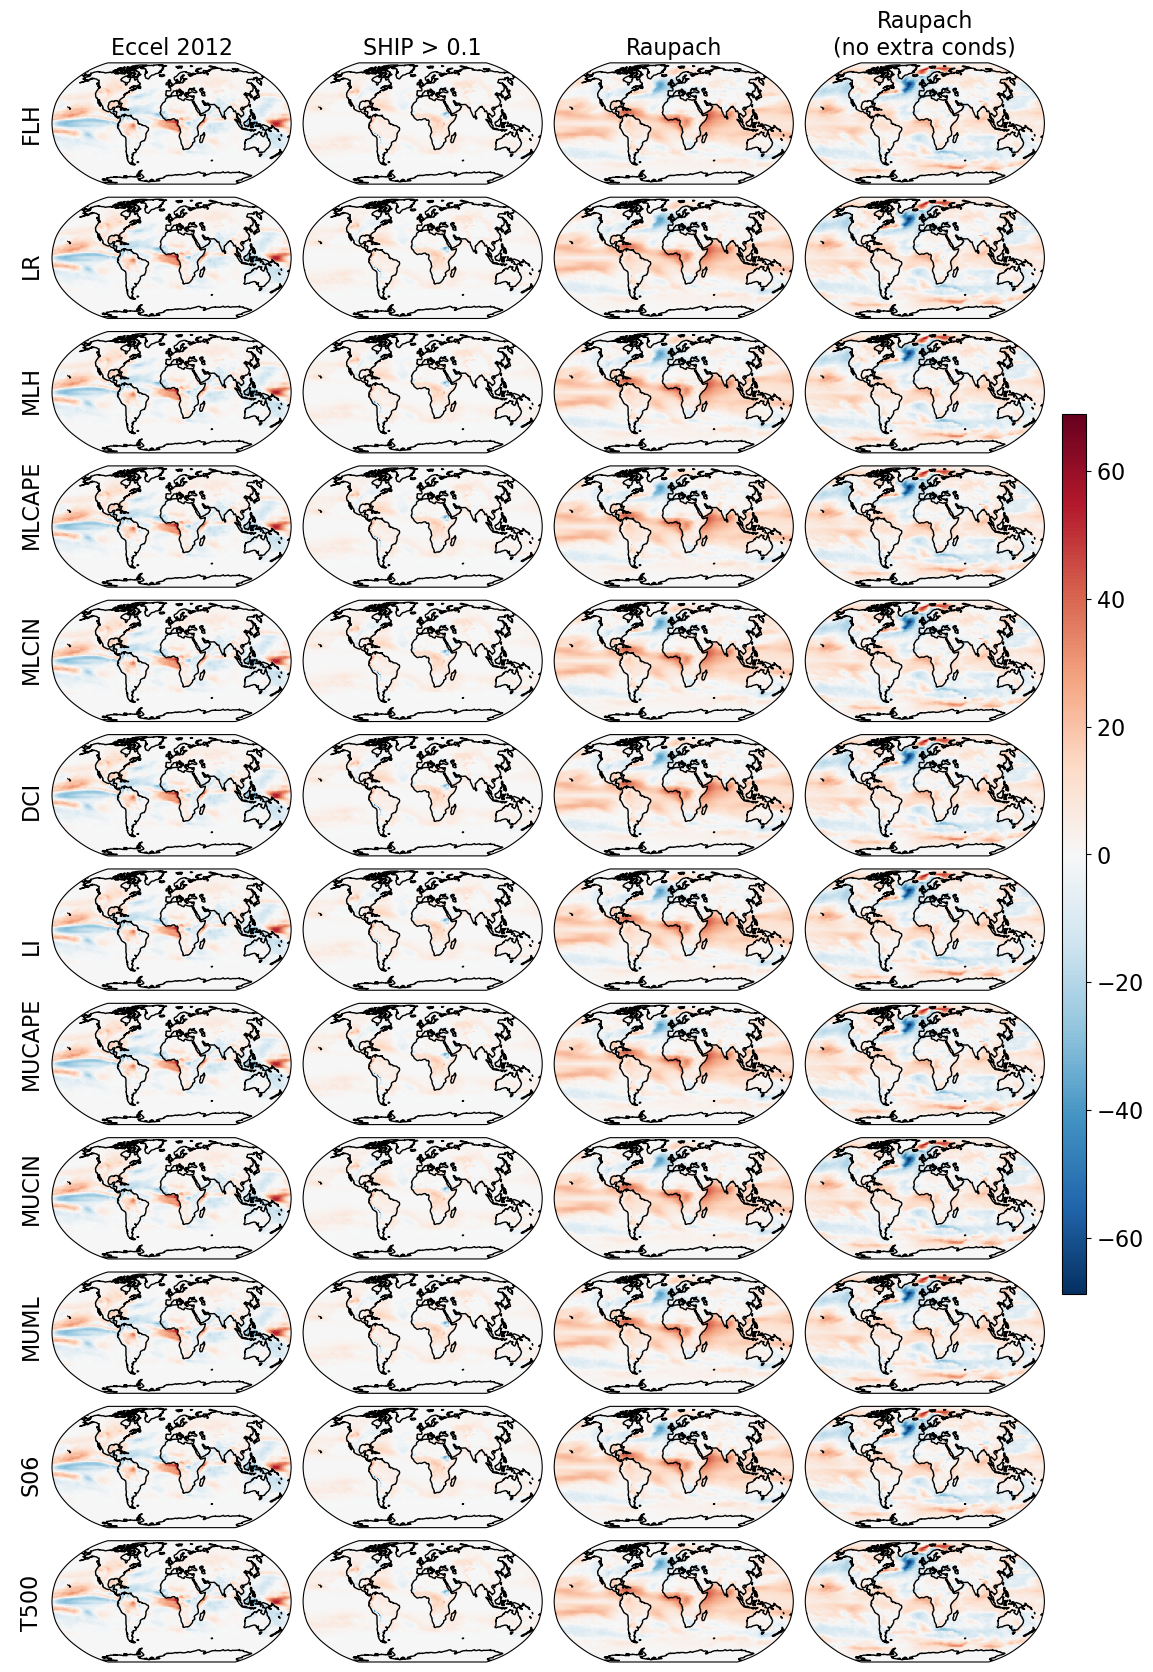

In [79]:
ing_names = {
    "freezing_level": "FLH",
    "lapse_rate_700_500": "LR",
    "melting_level": "MLH",
    "mixed_100_cape": "MLCAPE",
    "mixed_100_cin": "MLCIN",
    "mixed_100_dci": "DCI",
    "mixed_100_lifted_index": "LI",
    "mu_cape": "MUCAPE",
    "mu_cin": "MUCIN",
    "mu_mixing_ratio": "MUML",
    "shear_magnitude": "S06",
    "temp_500": "T500",
}

_ = fh.plot_map([drivers.sel(detrended_ing=ing, proxy=p) for ing, p in itertools.product(drivers.detrended_ing.values, drivers.proxy.values)],
    cmap="RdBu_r",
    divergent=True,
    nrows=len(drivers.detrended_ing),
    ncols=len(drivers.proxy),
    figsize=(12, 16),
    share_scale=True,
    hspace=0.1,
    disp_proj=ccrs.Robinson(),
    grid=False,
    row_labels=[ing_names[x] for x in drivers.detrended_ing.values],
    row_label_adjust=0.035,
    row_label_scale=1.3,
    row_label_offset=-0.08,
    col_labels=[fh.proxy_dims[f] for f in drivers.proxy.values],
)